In [1]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 696.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

## I. MNIST Data

### Exercice 1 : Loading Data

In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [56]:
from torch.utils.data import DataLoader, random_split, Subset

def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    indices = np.random.permutation(len(dataset))[:n_samples_per_node * nb_nodes]

    indices_split = np.array_split(indices, nb_nodes)

    data_loaders = []
    for node_indices in indices_split:
        subset = Subset(dataset, node_indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        data_loaders.append(loader)
    return data_loaders

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [58]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### TO DO ####
    digits_per_node = np.array_split(digits, nb_nodes)

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes * n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values correponding to idx of elements to keep in images_train_mnist and labels_train_mnist
        ### TO DO ###
        mask = torch.isin(labels_train_mnist, torch.tensor(digits_per_node[i], dtype=torch.int64))
        # append data_splitted with current data loader
        ### TO DO ###
        node_images = images_train_mnist[mask][:n_samples_per_node]
        node_labels = labels_train_mnist[mask][:n_samples_per_node]
        node_dataset = list(zip(node_images, node_labels))
        node_loader = DataLoader(node_dataset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(node_loader)
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [59]:
from torchvision import datasets, transforms

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Unknown type parameter. It should be either 'iid' or 'non_iid'.")

    return train_loaders, test_loaders

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [60]:
mnist_iid_train, mnist_iid_test = get_MNIST()

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [62]:
def plot_samples(data, channel:int, title=None, n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")
    plt.tight_layout()

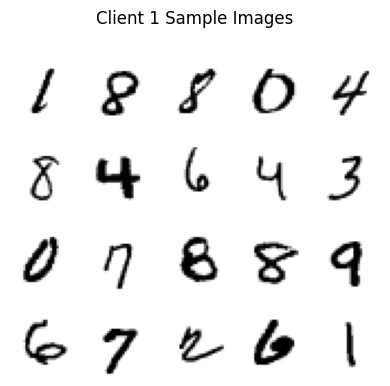

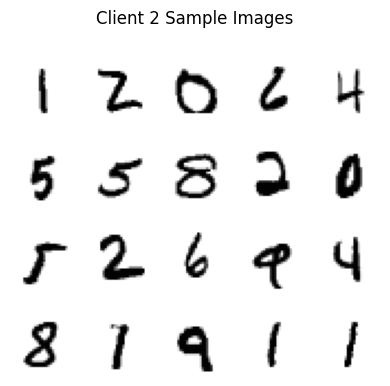

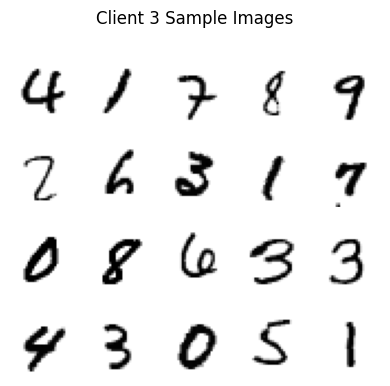

In [64]:
client1_images, client1_labels = next(iter(mnist_iid_train[0]))
plot_samples((client1_images, client1_labels), channel=0, title="Client 1 Sample Images", n_examples=20)

client2_images, client2_labels = next(iter(mnist_iid_train[1]))
plot_samples((client2_images, client2_labels), channel=0, title="Client 2 Sample Images", n_examples=20)

client3_images, client3_labels = next(iter(mnist_iid_train[2]))
plot_samples((client3_images, client3_labels), channel=0, title="Client 3 Sample Images", n_examples=20)

plt.show()

6) Plot samples this time for non_iid data for 3 clients.

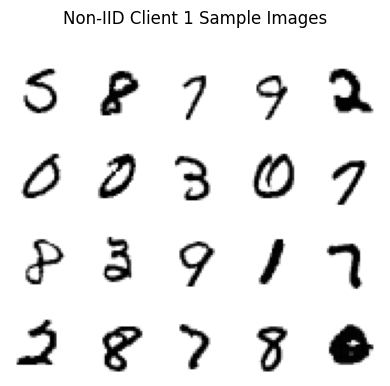

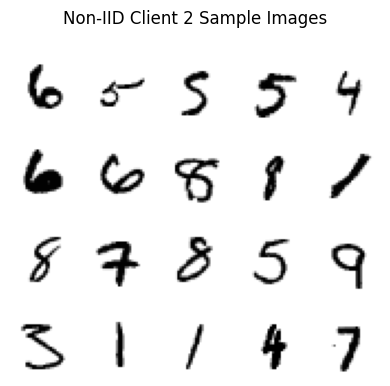

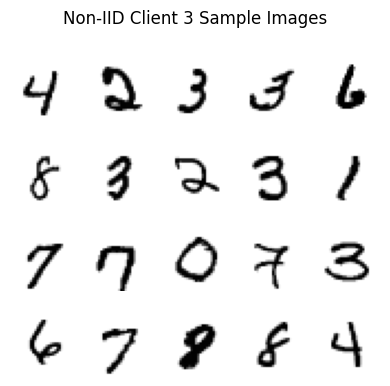

In [65]:
mnist_non_iid_train, _ = get_MNIST()

client1_images_non_iid, client1_labels_non_iid = next(iter(mnist_non_iid_train[0]))
plot_samples((client1_images_non_iid, client1_labels_non_iid), channel=0, title="Non-IID Client 1 Sample Images", n_examples=20)

client2_images_non_iid, client2_labels_non_iid = next(iter(mnist_non_iid_train[1]))
plot_samples((client2_images_non_iid, client2_labels_non_iid), channel=0, title="Non-IID Client 2 Sample Images", n_examples=20)

client3_images_non_iid, client3_labels_non_iid = next(iter(mnist_non_iid_train[2]))
plot_samples((client3_images_non_iid, client3_labels_non_iid), channel=0, title="Non-IID Client 3 Sample Images", n_examples=20)

plt.show()

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [66]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [67]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    # Extract parameters
    params1 = [p.data for p in model_1.parameters()]
    params2 = [p.data for p in model_2.parameters()]
    diff = sum([(p1 - p2).pow(2).sum() for p1, p2 in zip(params1, params2)])
    return diff.item()


Here is the function to perform one epoch of training data.

In [68]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [69]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    ### TO DO ###
    model_0 = deepcopy(model)

    for epoch in range(epochs):
        local_loss= train_step(model, model_0, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [70]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [71]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [72]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model=deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer= torch.optim.SGD(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss= local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [73]:
mnist_iid_train, mnist_iid_test = get_MNIST()

initial_model = CNN()

final_model, loss_history, accuracy_history = FedProx(initial_model, mnist_iid_train, 10, mnist_iid_test)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3043990929921465 Server Test Accuracy: 12.0
====> i: 1 Loss: 2.255659182866414 Server Test Accuracy: 9.666666666666666
====> i: 2 Loss: 2.1956652800242105 Server Test Accuracy: 20.0
====> i: 3 Loss: 2.09169332186381 Server Test Accuracy: 39.0
====> i: 4 Loss: 1.874604066212972 Server Test Accuracy: 47.0
====> i: 5 Loss: 1.4522310495376587 Server Test Accuracy: 60.33333333333333
====> i: 6 Loss: 0.9752744436264037 Server Test Accuracy: 71.66666666666666
====> i: 7 Loss: 0.674474040667216 Server Test Accuracy: 80.0
====> i: 8 Loss: 0.5117278893788655 Server Test Accuracy: 84.66666666666666
====> i: 9 Loss: 0.4103454450766245 Server Test Accuracy: 84.66666666666666
====> i: 10 Loss: 0.34895609815915424 Server Test Accuracy: 85.33333333333333


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [76]:
def plot_acc_loss(title, loss_hist, acc_hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(loss_hist, color='blue', label='Loss')
    ax1.set_title('Loss history')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(acc_hist, color='red', label='Accuracy')
    ax2.set_title('Accuracy history')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    fig.suptitle(title)
    plt.show()

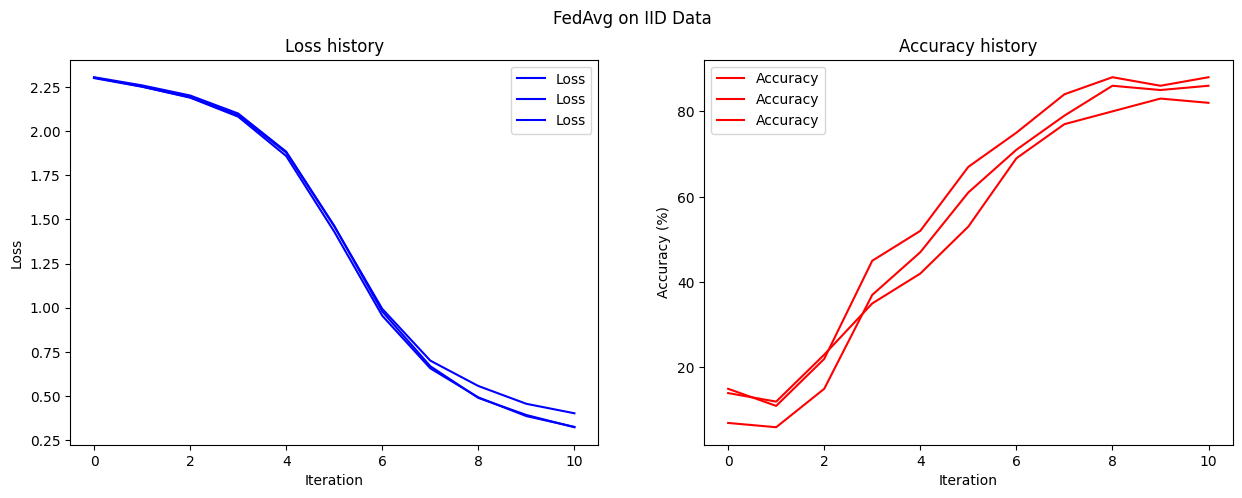

In [78]:
plot_acc_loss("FedAvg on IID Data", loss_history, accuracy_history)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3019069830576577 Server Test Accuracy: 8.0
====> i: 1 Loss: 1.9050445954004922 Server Test Accuracy: 52.33333333333333
====> i: 2 Loss: 0.9170461297035217 Server Test Accuracy: 76.0
====> i: 3 Loss: 0.5025415917237599 Server Test Accuracy: 84.66666666666666
====> i: 4 Loss: 0.35410095254580176 Server Test Accuracy: 84.0
====> i: 5 Loss: 0.191314955552419 Server Test Accuracy: 92.66666666666666
====> i: 6 Loss: 0.13897282630205154 Server Test Accuracy: 90.66666666666666
====> i: 7 Loss: 0.12573722501595813 Server Test Accuracy: 91.66666666666666
====> i: 8 Loss: 0.07463670273621877 Server Test Accuracy: 91.66666666666666
====> i: 9 Loss: 0.07508713255325952 Server Test Accuracy: 90.66666666666666
====> i: 10 Loss: 0.0446091778576374 Server Test Accuracy: 93.0


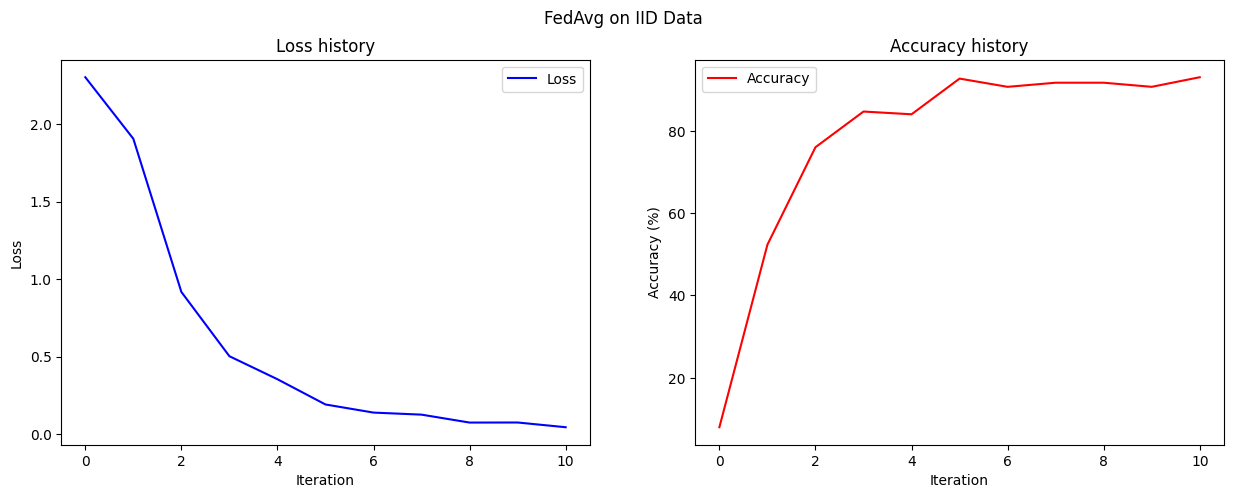

In [79]:
mnist_iid_train, mnist_iid_test = get_MNIST()

epochs = 2
lr = 0.1
mu = 0.3
n_iter = 10

n_samples = sum([len(dl.dataset) for dl in mnist_iid_train])
weights = [len(dl.dataset) / n_samples for dl in mnist_iid_train]

model = CNN()

final_model, loss_history, acc_history = FedProx(model, training_sets=mnist_iid_train, n_iter=n_iter, testing_sets=mnist_iid_test, mu=mu, epochs=epochs, lr=lr)

server_loss = [sum([weights[i] * loss_history[iteration][i] for i in range(len(weights))]) for iteration in range(len(loss_history))]
server_accuracy = [sum([weights[i] * acc_history[iteration][i] for i in range(len(weights))]) for iteration in range(len(acc_history))]
plot_acc_loss("FedAvg on IID Data", server_loss, server_accuracy)

4) What do you observe ?

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

<ipython-input-58-c5fee84b877b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.isin(labels_train_mnist, torch.tensor(digits_per_node[i], dtype=torch.int64))


Clients' weights: [0.35842293906810035, 0.32616487455197135, 0.3154121863799283]
====> i: 0 Loss: 2.3003409814663685 Server Test Accuracy: 6.439796762377408
====> i: 1 Loss: 2.2221756434355155 Server Test Accuracy: 10.39820394659104
====> i: 2 Loss: 1.9137216729502522 Server Test Accuracy: 45.66031497270886
====> i: 3 Loss: 1.4257038643710502 Server Test Accuracy: 68.57549166547469
====> i: 4 Loss: 0.8447115703295636 Server Test Accuracy: 77.48392901194259
====> i: 5 Loss: 0.7040561115015365 Server Test Accuracy: 78.02384372842776
====> i: 6 Loss: 0.5938035015777875 Server Test Accuracy: 81.68321962889026
====> i: 7 Loss: 0.5350885174394081 Server Test Accuracy: 82.33657966255589
====> i: 8 Loss: 0.42382281495251534 Server Test Accuracy: 85.30984201612384
====> i: 9 Loss: 0.33838500867607774 Server Test Accuracy: 84.4844223876482
====> i: 10 Loss: 1.4735214842690363 Server Test Accuracy: 73.70639170299611


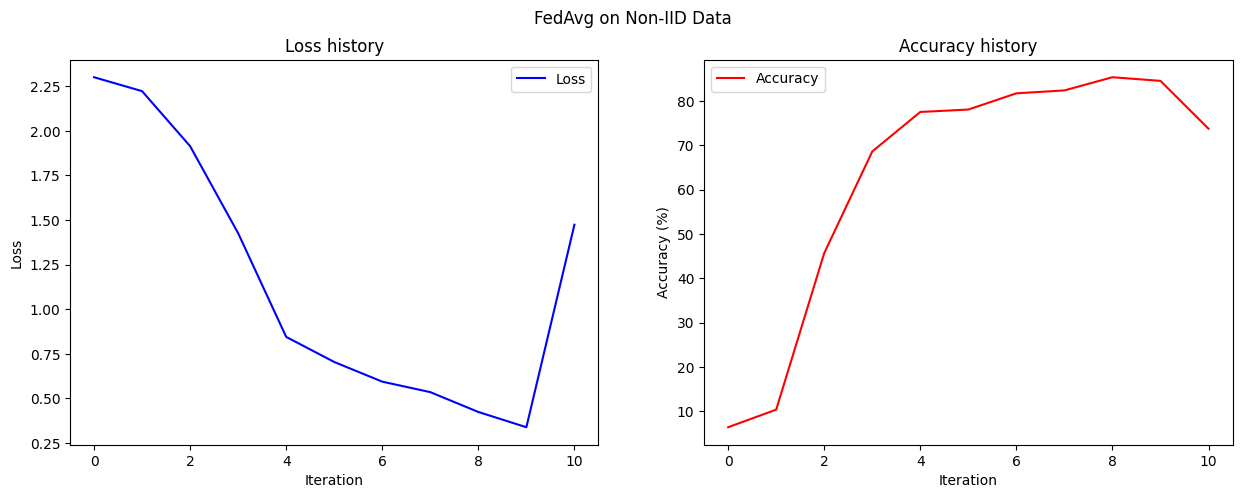

In [80]:
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(type="non_iid")

n_samples = sum([len(dl.dataset) for dl in mnist_non_iid_train])
weights = [len(dl.dataset) / n_samples for dl in mnist_non_iid_train]

model_non_iid = CNN()

final_model, loss_hist_fedavg, acc_hist_fedavg = FedProx(model_non_iid, training_sets=mnist_non_iid_train, testing_sets=mnist_non_iid_test, n_iter=10, mu=0, epochs=2, lr=0.1, decay=1)

server_loss_fedavg = [sum([weights[i] * loss_hist_fedavg[iteration][i] for i in range(len(weights))]) for iteration in range(len(loss_hist_fedavg))]
server_accuracy_fedavg = [sum([weights[i] * acc_hist_fedavg[iteration][i] for i in range(len(weights))]) for iteration in range(len(acc_hist_fedavg))]
plot_acc_loss("FedAvg on Non-IID Data", server_loss_fedavg, server_accuracy_fedavg)

2) What do you observe ?

On peut observer que la loss remonte a la 10eme iteration

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [81]:
! pip install medmnist

Import medmnist

In [82]:
import medmnist

You can list all available datasets with this command

In [83]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [84]:
from medmnist import BloodMNIST

In [85]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [86]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
download_path = '.'

train_dataset = BloodMNIST(root=download_path, split='train', transform=transform, download=True)
test_dataset = BloodMNIST(root=download_path, split='test', transform=transform, download=True)

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [87]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Apply the preprocessing pipeline to the datasets
train_data = CustomDataset(train_dataset, transform=transform)
test_data = CustomDataset(test_dataset, transform=transform)


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

In [88]:
train_image, train_label = train_dataset[0]
print("Training Sample Image Shape:", train_image.size())
print("Training Sample Label:", train_label)

test_image, test_label = test_dataset[0]
print("\nTest Sample Image Shape:", test_image.size())
print("Test Sample Label:", test_label)

Training Sample Image Shape: torch.Size([3, 28, 28])
Training Sample Label: [7]

Test Sample Image Shape: torch.Size([3, 28, 28])
Test Sample Label: [3]


5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [89]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [90]:
def non_iid_split(dataset, clients):
    """
    Split a dataset into non-IID subsets.
    """
    num_items_per_class = len(dataset) // 8
    class_items = {}

    for i in range(8):
        class_items[i] = []

    for item in dataset:
        _, label = item
        class_items[label].append(item)

    client_datasets = []
    items_per_client = len(dataset) // clients
    classes_per_client = 8 // clients

    for i in range(clients):
        client_data = []
        for j in range(classes_per_client):
            client_data.extend(class_items[i*classes_per_client + j][:num_items_per_class//clients])
        client_datasets.append(client_data)

    return client_datasets


In [91]:
def iid_split(dataset, clients):
    """
    Split a dataset into IID subsets.
    """
    total_items = len(dataset)
    items_per_client = total_items // clients
    client_datasets = []

    all_indices = np.arange(total_items)
    np.random.shuffle(all_indices)

    for i in range(clients):
        indices = all_indices[i*items_per_client:(i+1)*items_per_client]
        client_data = [dataset[i] for i in indices]
        client_datasets.append(client_data)

    return client_datasets


In [92]:
def get_MNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    download_path = '.'

    train_dataset = BloodMNIST(root=download_path, split='train', transform=transform, download=True)
    test_dataset = BloodMNIST(root=download_path, split='test', transform=transform, download=True)

    return train_dataset, test_dataset


In [93]:
import matplotlib.pyplot as plt

def plot_samples(dataset, title="Samples", num_samples=10):
    """Plot random samples from a dataset."""
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    random_idxs = np.random.choice(len(dataset), size=num_samples, replace=False)

    for idx, ax in zip(random_idxs, axes):
        image, label = dataset[idx]

        image = image.permute(1, 2, 0)

        image = (image + 1) / 2.0

        ax.imshow(image.squeeze(), cmap='gray' if image.shape[2] == 1 else None)
        ax.set_title(f"Class: {label}")
        ax.axis("off")

    plt.suptitle(title)
    plt.show()


### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [94]:
train_dataset, test_dataset = get_MNIST()

clients_train_datasets = iid_split(train_dataset, clients=3)

clients_test_datasets = iid_split(test_dataset, clients=3)

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


2. plost samples with corresponding function.

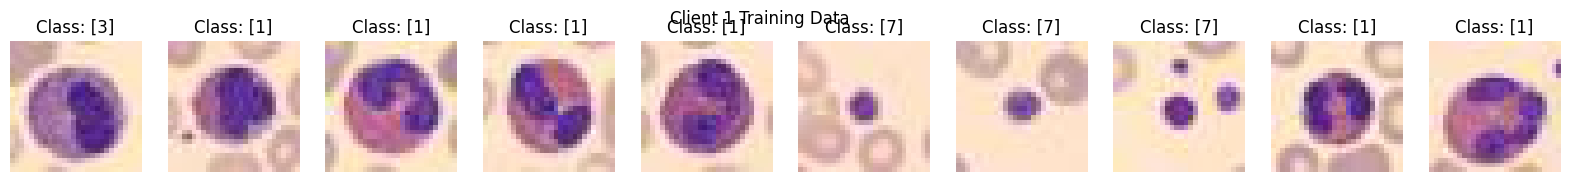

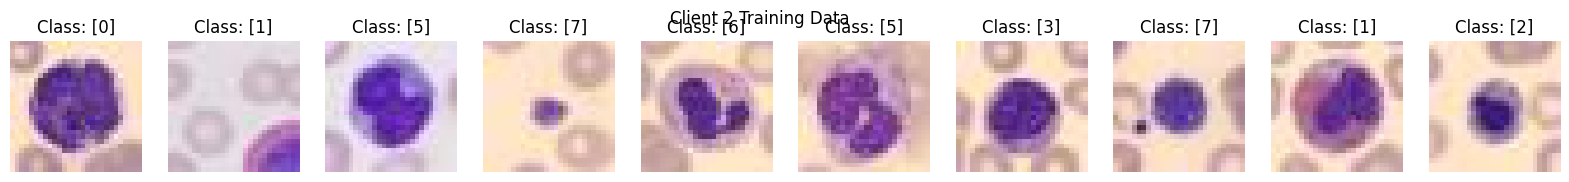

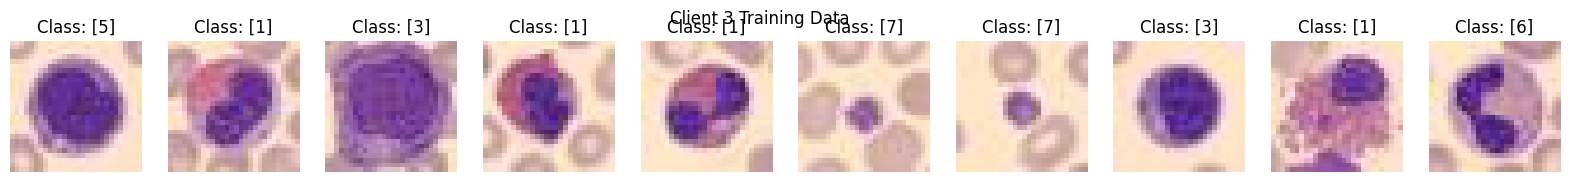

In [95]:
for i, client_data in enumerate(clients_train_datasets):
    plot_samples(client_data, title=f"Client {i+1} Training Data")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf